In [1]:
import os
import pywt
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from quantus.metrics import Complexity
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset


from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions
from src.attribution.wavelet.wavelet import WaveletFilterbank


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_4.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [3]:
# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_2"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)


File not recognized
File not recognized
(10000, 1, 16)
(10000,)


In [4]:
print(f"Number of batches: {len(test_loader)}")
for batch in test_loader:
    print(f"Batch shape {len(batch)}, sample and label")
    x, y = batch
    print(f"Sample batch size {len(x)}")
    print(f"Label batch size {len(y)}")
    print(f"Sample shape {x.shape}")
    print(f"Label shape {y.shape}")
    break

Number of batches: 79
Batch shape 2, sample and label
Sample batch size 128
Label batch size 128
Sample shape torch.Size([128, 1, 16])
Label shape torch.Size([128])


In [5]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [6]:
print(predictions.shape)
print(predictions[0])
print(labels.shape)

torch.Size([10000, 2])
tensor([-6.7930,  7.3255], device='mps:0', grad_fn=<SelectBackward0>)
torch.Size([10000])


In [7]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [8]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [9]:
# evaluate wavelet
fs = 16
batch_size = 128
wavelet = 'db'
w_len = 1
level = pywt.dwt_max_level(fs, 'db1')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_db1_4_128


In [10]:
# compute the attributions
method = 'wavelet'

args = SimpleNamespace(wavelet=wavelet, len_w=w_len, level=level, sample_freq=fs)
print(args.wavelet)
print(args.len_w)
print(args.level)
print(args.sample_freq)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device)
# last time took 68mins approximately

db
1
4
16
Batch 0 of 79
Sample 0 of 128
Epoch 0: Loss=1.7592, Target=1.3092, Reg=0.4500
Epoch 10: Loss=1.6387, Target=1.2850, Reg=0.3536
Epoch 20: Loss=0.9540, Target=0.6728, Reg=0.2812
Epoch 30: Loss=0.5401, Target=0.3207, Reg=0.2194
Epoch 40: Loss=0.4689, Target=0.3143, Reg=0.1546
Epoch 50: Loss=0.4020, Target=0.3137, Reg=0.0883
Epoch 60: Loss=0.3846, Target=0.3136, Reg=0.0710
Epoch 70: Loss=0.3716, Target=0.3136, Reg=0.0580
Epoch 80: Loss=0.3609, Target=0.3136, Reg=0.0474
Epoch 90: Loss=0.3548, Target=0.3136, Reg=0.0412
Epoch 100: Loss=0.3484, Target=0.3136, Reg=0.0348
Epoch 110: Loss=0.3418, Target=0.3136, Reg=0.0282
Epoch 120: Loss=0.3386, Target=0.3137, Reg=0.0249
Epoch 130: Loss=0.3359, Target=0.3137, Reg=0.0222
Epoch 140: Loss=0.3331, Target=0.3138, Reg=0.0193
Epoch 150: Loss=0.3302, Target=0.3138, Reg=0.0163
Epoch 160: Loss=0.3272, Target=0.3139, Reg=0.0133
Epoch 170: Loss=0.3242, Target=0.3140, Reg=0.0102
Epoch 180: Loss=0.3210, Target=0.3141, Reg=0.0069
Epoch 190: Loss=0.317

In [11]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [12]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])
wavelet_db1_4_128
1
128
1
79


In [ ]:
# # read data
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_4.pkl'

# with open(path, 'rb') as f:
#     attributions = pickle.load(f)
# print(f"Attributions loaded from {path}")

FileNotFoundError: [Errno 2] No such file or directory: 'public/simple/wavelet_db1_4_128_results_4.pkl'

In [13]:
# print the type of attributions[key_]
print(type(attributions[key_]))

<class 'list'>


In [14]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))

<class 'list'>
1
128
1
16


In [15]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))
print(len(attributions[key_2][0][0][0]))

<class 'list'>
1
128
16
4


In [ ]:
# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device, domain='wavelet', wavelet='db1')
    attributions[mode][key_] = acc_scores

shape of x: torch.Size([128, 1, 16])
Data shape: torch.Size([128, 1, 16, 5])


IndexError: list index out of range

In [16]:
print(attributions.keys())
# print(len(quantiles))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])


In [17]:
# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

In [18]:
complexities = {}
grad_complexties = {}
comp = Complexity()

In [19]:
# for att in attributions:
#     if att == 'insertion':
#         print(attributions['insertion'].keys())
    
# for key in attributions['insertion'].keys():
key = 'wavelet_db1_4_128'
if not key in complexities.keys():
    print('first')
    complexities[key] = []
    grad_complexties[key] = []

scores = []
grad_scores = []

for i in range(len(attributions[key])):
    expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    expl = expl.to(dtype=torch.float32).numpy()
    
    ex = np.maximum(attributions[key][i].numpy(), 0)
    if 'filterbank' in key:
        ex = np.transpose(ex, (0, 2, 1))

    # min max normalize
    ex_min = np.min(ex, axis = -1, keepdims=True)
    ex_max = np.max(ex, axis = -1, keepdims=True)
    ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
    # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
    expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
    expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

    expl = np.maximum(expl, 0)
    # check if all expl values are zero
    if np.all(expl == 0):
        print("All zeros")
        # add a small epsilon to avoid division by zero
        expl = np.ones_like(expl) * 1e-10

    # to compute complexities it has to be a numpy float32 otherwise err
    complexity = comp.evaluate_batch(expl, expl)
    complexity = np.nan_to_num(complexity)
    expl_grad = np.nan_to_num(expl_grad)
    scores += complexity.tolist()
    grad_scores += list(expl_grad)

complexities[key].append(np.mean(scores))
grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

first
{'wavelet_db1_4_128': [np.float64(1.1111599870303945)]}
{'wavelet_db1_4_128': [np.float32(0.3569647)]}


In [22]:
import pickle

# dump to file
folder = 'public/simple/'
path = f'{folder}{key_}_results_3.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/simple/wavelet_db1_9_128_results_3.pkl


In [26]:
def plot_freq_heatmap(signal, attribution, fs=100):
    # Compute FFT
    N = len(signal)
    freq = fftfreq(N, d=1/fs)  # Frequency bins
    magnitude = np.abs(fft(signal))  # Magnitude of FFT

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    # freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                                    
    print(freq_bands)

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # sum the attribution scores across the time dimension
    attribution = np.sum(attribution, axis=0)
    print(attribution.shape)

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, freq_bands, attribution)
    # attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    freq_grid, mag_grid = np.meshgrid(freq, magnitude)
    attr_grid = np.tile(attr_norm[:-1], (len(magnitude) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude, label="FFT Magnitude", color='black', alpha=0.6)
    plt.pcolormesh(freq_grid, mag_grid, attr_grid, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Attribution Heatmap in Frequency Domain")
    plt.show()

In [38]:
import pywt

def plot_scaleogram_wav_heatmap(signal, attribution, fs=1000, level=9):
    print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
    freq_bands.append(0)                                        # lowest frequency
    print(freq_bands)

    time = np.linspace(0, len(signal) / fs, len(signal))

    # normalize attribution scores to [0,1]
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[:-1, :]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title('Attribution')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [22]:
# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

1
(128, 16, 4)
[1.0, 2.0, 4.0, 8.0]
(4,)


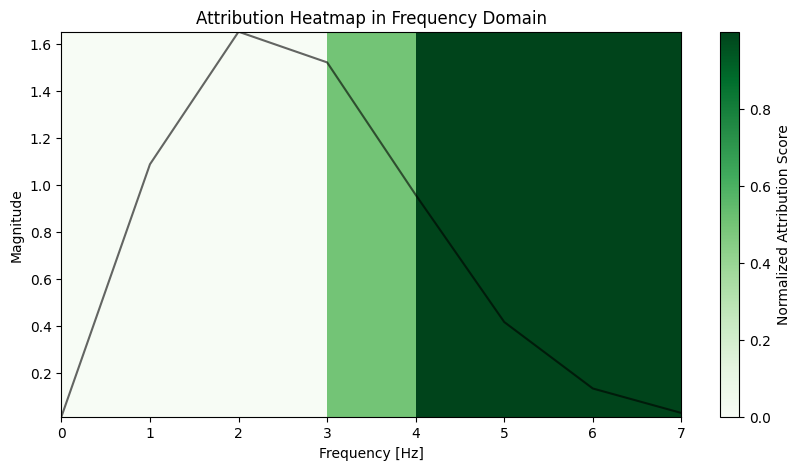

Prediction: 0, Label: 0
[1.0, 2.0, 4.0, 8.0]
(4,)


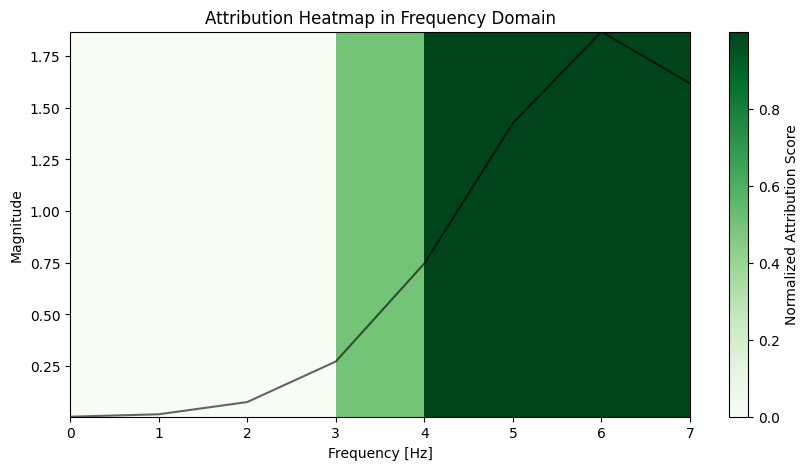

Prediction: 0, Label: 0
[1.0, 2.0, 4.0, 8.0]
(4,)


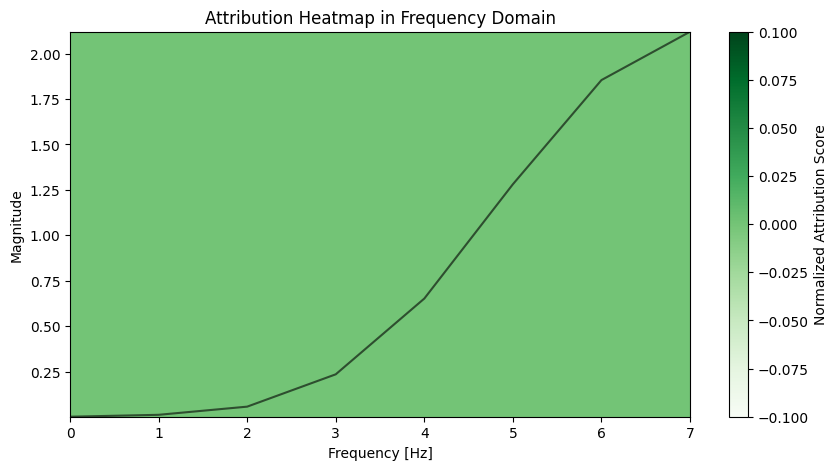

Prediction: 0, Label: 0
[1.0, 2.0, 4.0, 8.0]
(4,)


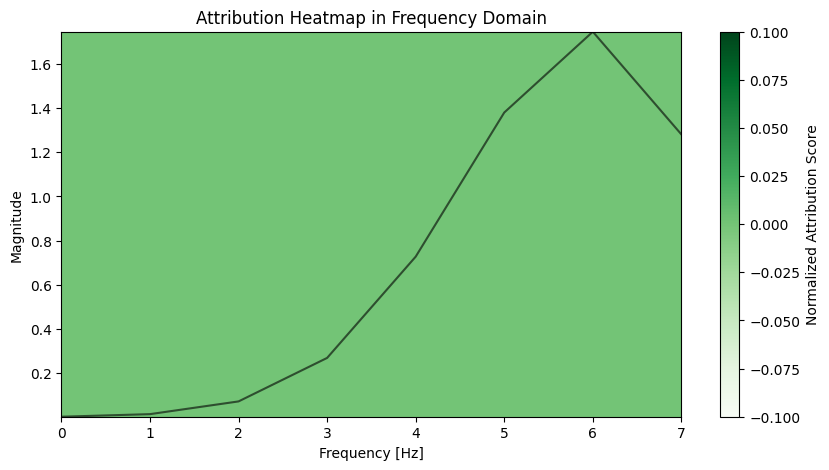

Prediction: 0, Label: 0
[1.0, 2.0, 4.0, 8.0]
(4,)


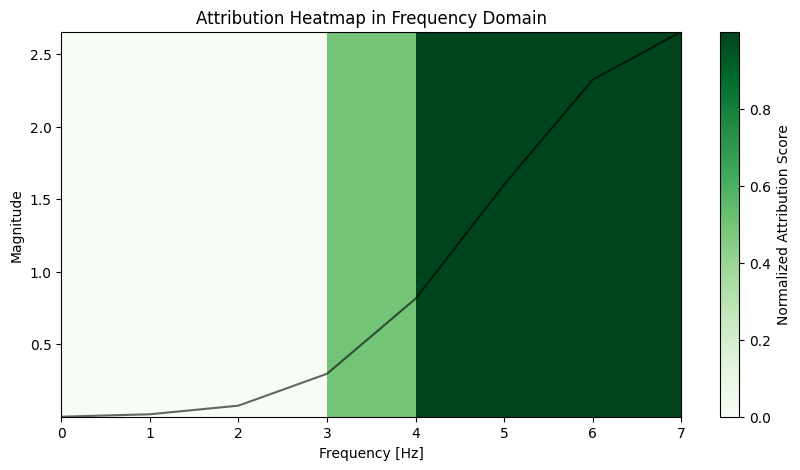

Prediction: 1, Label: 1
[1.0, 2.0, 4.0, 8.0]
(4,)


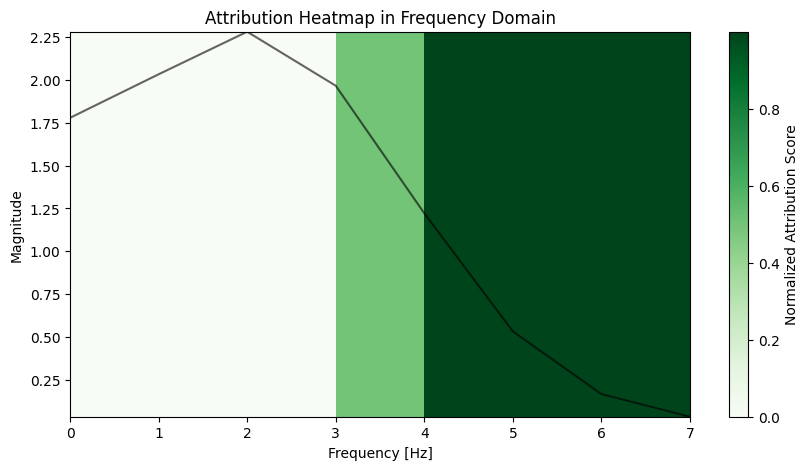

Prediction: 1, Label: 1
[1.0, 2.0, 4.0, 8.0]
(4,)


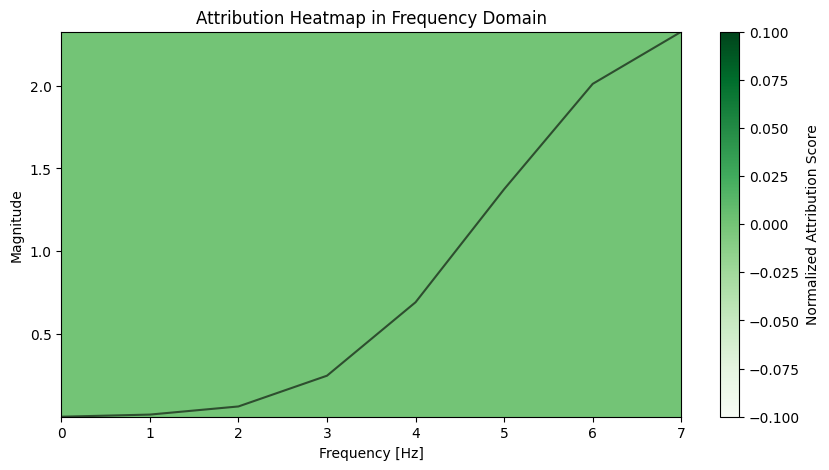

Prediction: 1, Label: 1
[1.0, 2.0, 4.0, 8.0]
(4,)


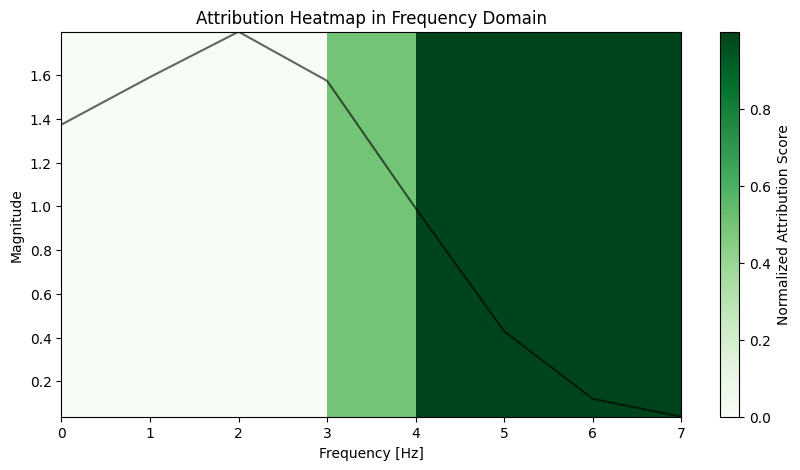

Prediction: 0, Label: 0
[1.0, 2.0, 4.0, 8.0]
(4,)


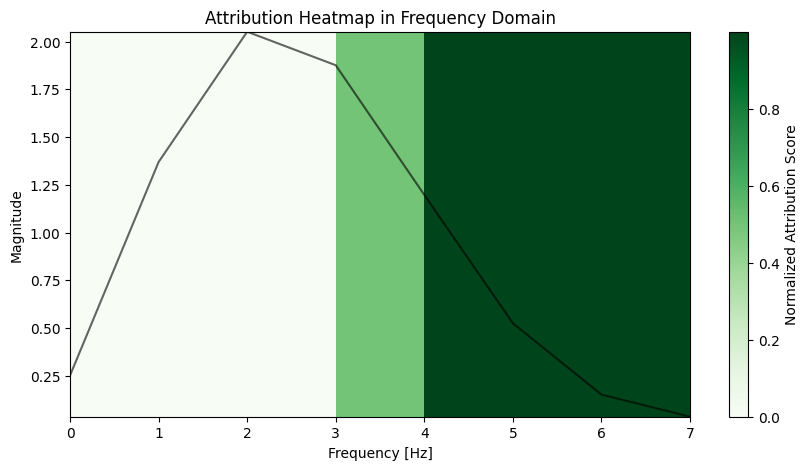

Prediction: 1, Label: 1


In [28]:
# plot the scores as a heatmap on the original signal
print(len(attributions['filtermasks_wavelet_db1_4_128']))
print(attributions['filtermasks_wavelet_db1_4_128'][0].shape)

# plot 5 samples
for i in range(1, 10):
    plot_freq_heatmap(x[i][0], attributions['filtermasks_wavelet_db1_4_128'][0][i], fs,)

    # print the prediction and the label
    print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")

(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


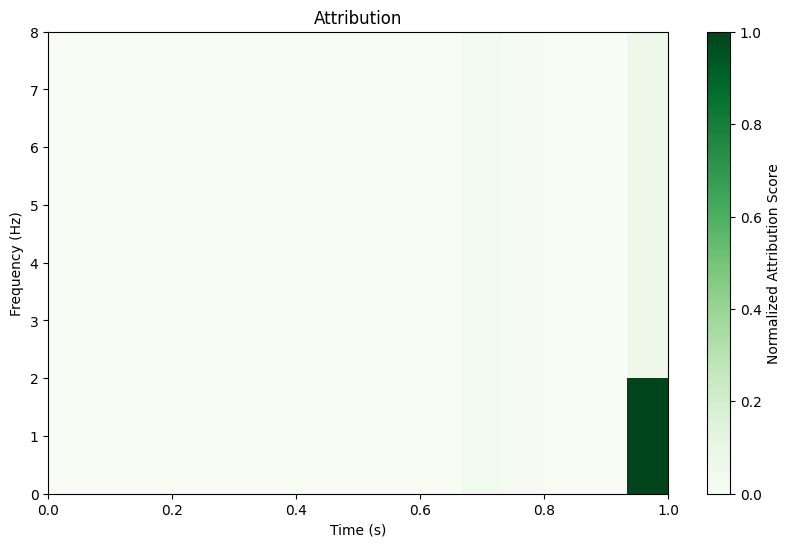

Prediction: 0, Label: 0
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


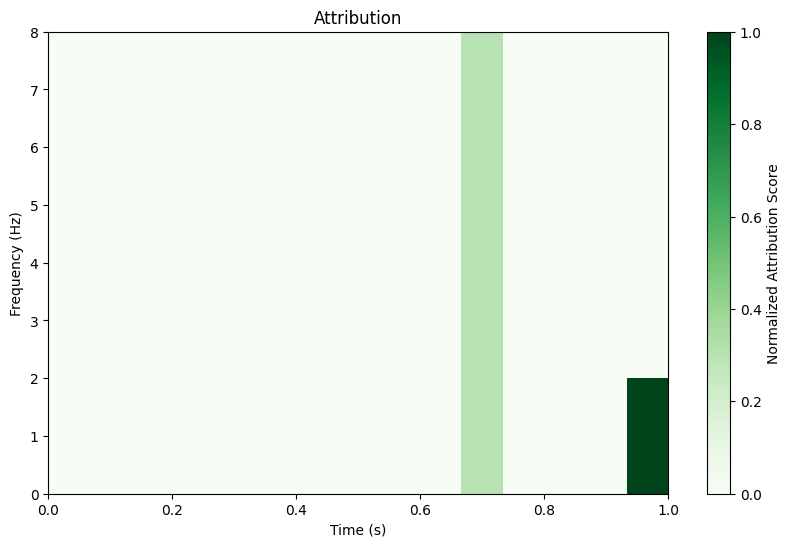

Prediction: 0, Label: 0
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


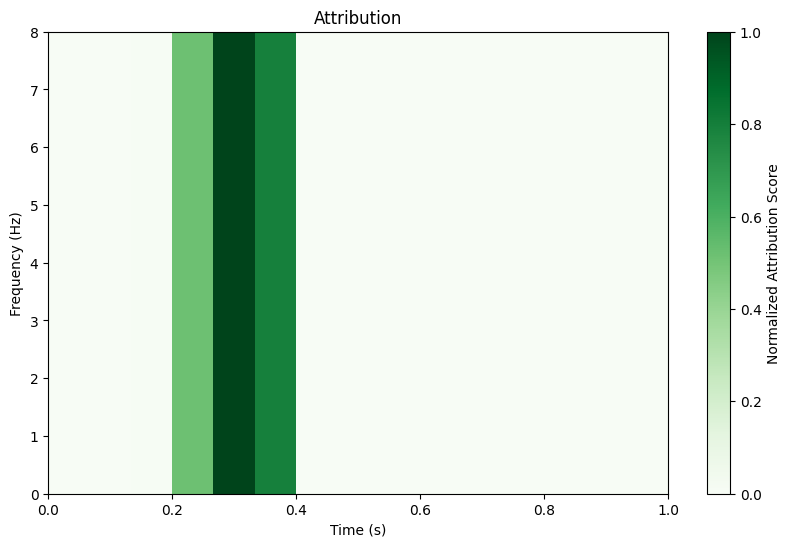

Prediction: 0, Label: 0
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


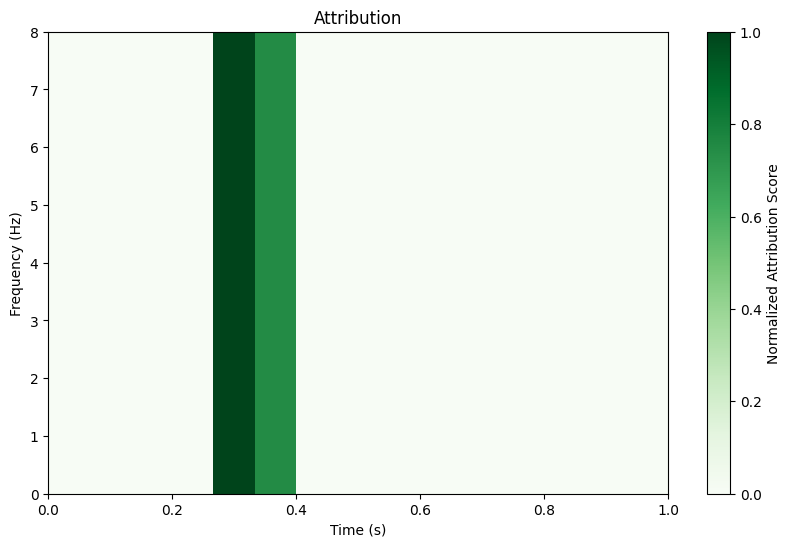

Prediction: 0, Label: 0
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


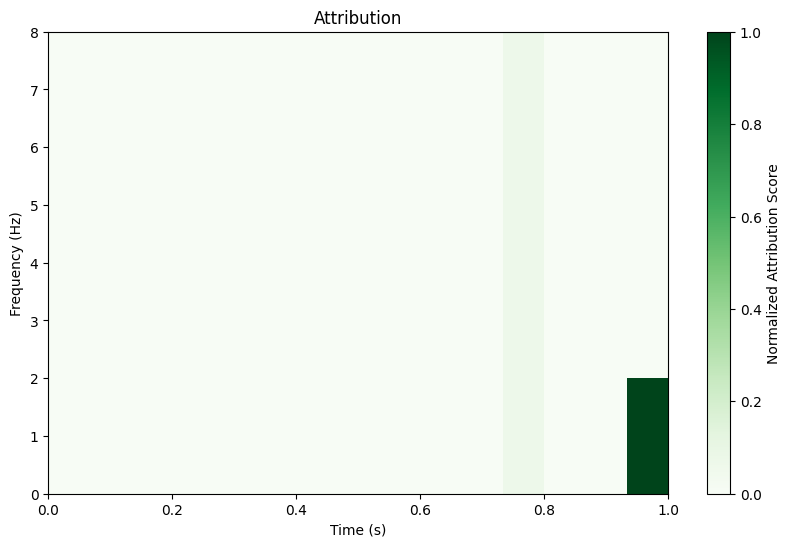

Prediction: 1, Label: 1
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


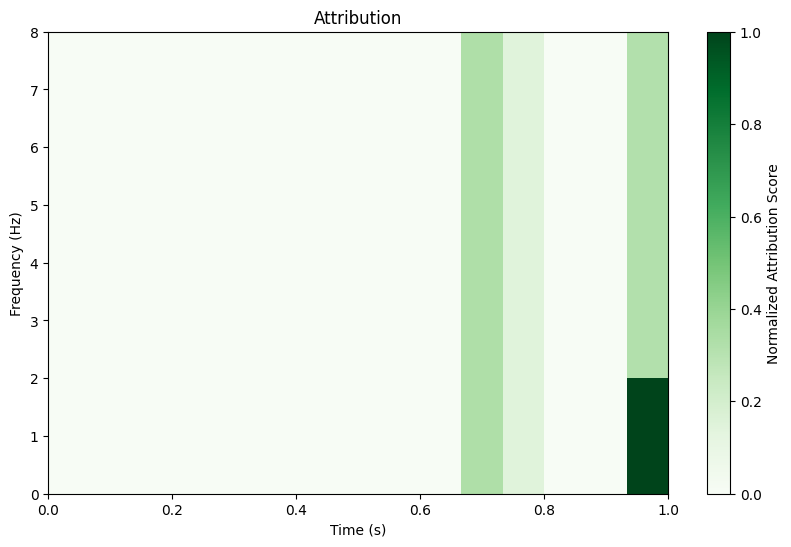

Prediction: 1, Label: 1
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


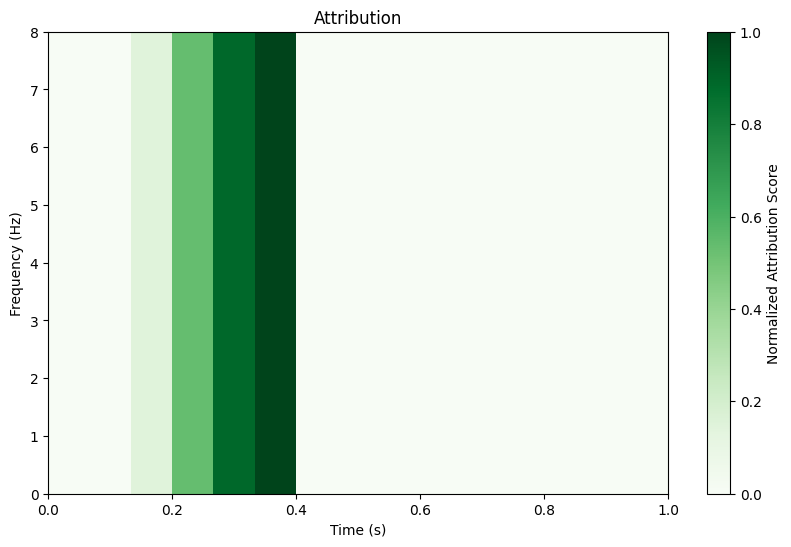

Prediction: 1, Label: 1
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


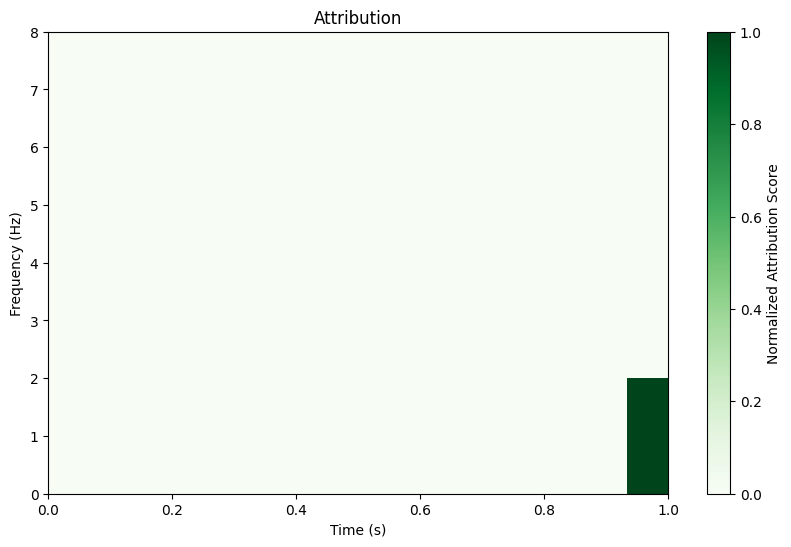

Prediction: 0, Label: 0
(16, 4)
[8.0, 4.0, 2.0, 1.0, 0]


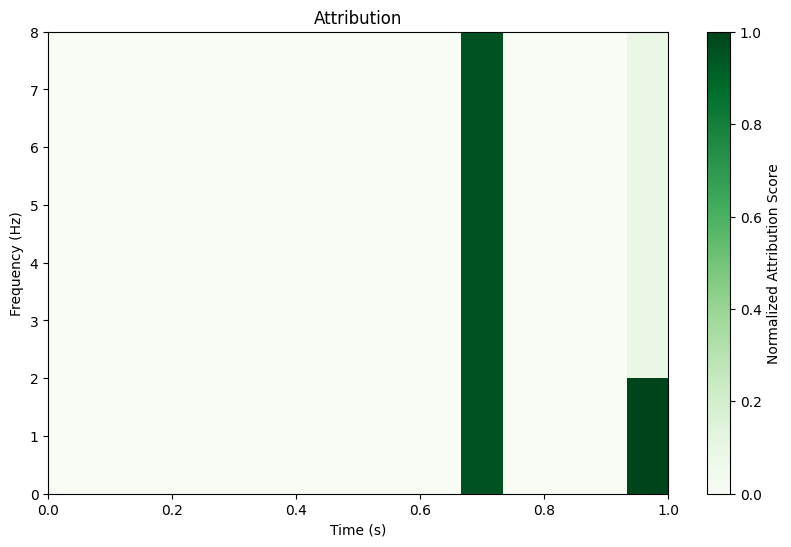

Prediction: 1, Label: 1


In [39]:
# plot the scores as a heatmap on the original signal
max_level = pywt.dwt_max_level(16, 'db1')

# plot 5 samples
for i in range(1, 10):
    plot_scaleogram_wav_heatmap(x[i][0], attributions['filtermasks_wavelet_db1_4_128'][0][i], fs, level=max_level)

    # print the prediction and the label
    print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")

In [17]:
# create a wavelet filterbank
import math

for i, batch in enumerate(test_loader):
    x, y = batch
    x = x.numpy()
    signal = torch.tensor(x[0][0])

    time_len = len(signal)

    print(signal.shape)
    print(time_len)

    break

print(x.shape)
coeffs = pywt.wavedec(x, 'db1')
print(len(coeffs))

wavelet_transform = []
for i in range(len(coeffs)):  # iterate over levels
    level_list = []
    for j in range(len(coeffs[i])):  # batch size
        batch_list = []
        for k in range(len(coeffs[i][j])):  # channels
            signal = coeffs[i][j][k]
            factor = math.ceil(time_len / len(signal))
            upsampled = np.repeat(signal, factor)[:time_len]
            batch_list.append(upsampled)
        level_list.append(batch_list)
    wavelet_transform.append(level_list)

wavelet_transform = np.array(wavelet_transform)
# move axis 0 to axis -1
wavelet_transform = np.moveaxis(wavelet_transform, 0, -1)
print(wavelet_transform.shape)

filterbank = WaveletFilterbank(wavelet='db', w_len=1, level=9, fs=1000)
filterbank.apply_dwt_filterbank(signal)
# create a tensor of 1 with shape 1000, 10
mask = None

imp = filterbank.get_filter_response(mask)
print(imp.shape)

bands = filterbank.get_wavelet_bands(True, True)
print(bands.shape)

torch.Size([1000])
1000
(128, 1, 1000)
10
(128, 1, 1000, 10)


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'ndim'

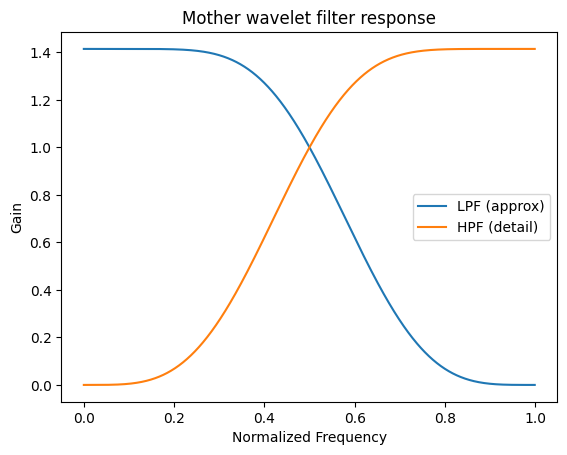

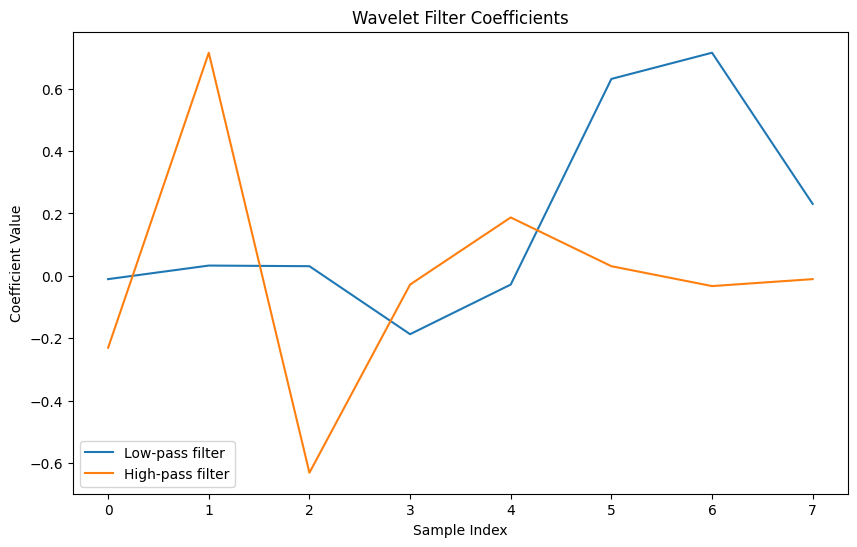

In [41]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

wavelet = pywt.Wavelet('db4')
dec_lo, dec_hi, _, _ = wavelet.filter_bank

# Frequency responses
w_lo, h_lo = freqz(dec_lo, worN=1024)
w_hi, h_hi = freqz(dec_hi, worN=1024)

plt.plot(w_lo / np.pi, abs(h_lo), label="LPF (approx)")
plt.plot(w_hi / np.pi, abs(h_hi), label="HPF (detail)")
plt.xlabel("Normalized Frequency")
plt.ylabel("Gain")
plt.legend()
plt.title("Mother wavelet filter response")
plt.show()


# plot the filter
plt.figure(figsize=(10, 6))
plt.plot(dec_lo, label='Low-pass filter')
plt.plot(dec_hi, label='High-pass filter')
plt.title('Wavelet Filter Coefficients')
plt.xlabel('Sample Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

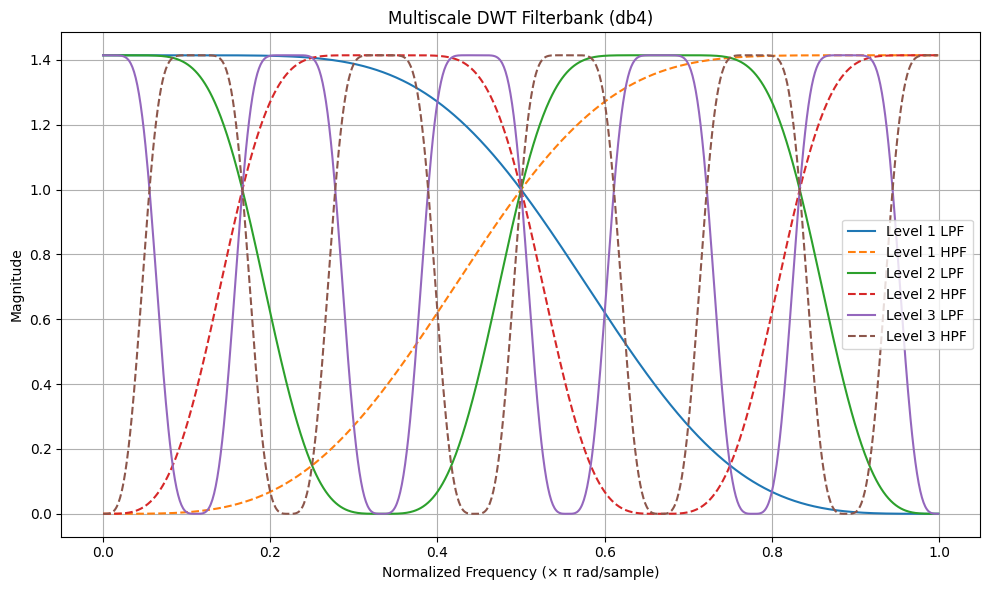

In [73]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Select wavelet and number of levels
wavelet = pywt.Wavelet('db4')
num_levels = 3  # Choose how many decomposition levels you want

# Get the decomposition low-pass and high-pass filter coefficients
dec_lo = wavelet.dec_lo  # Low-pass filter
dec_hi = wavelet.dec_hi  # High-pass filter

# Function to get frequency response for each level
def get_response(h, level):
    # Upsample by inserting 2**(level-1)-1 zeros between each coefficient
    h_up = np.copy(h)
    for _ in range(level - 1):
        h_up = np.insert(h_up, slice(1, None), 0)  # insert 0s between taps
        h_up = np.insert(h_up, slice(2, None, 2), 0)  # adjust for scale
    w, H = freqz(h_up, worN=1024)
    return w, np.abs(H)

# Plot the filter responses
plt.figure(figsize=(10, 6))

for level in range(1, num_levels + 1):
    w_lo, H_lo = get_response(dec_lo, level)
    w_hi, H_hi = get_response(dec_hi, level)

    plt.plot(w_lo / np.pi, H_lo, label=f'Level {level} LPF')
    plt.plot(w_hi / np.pi, H_hi, label=f'Level {level} HPF', linestyle='--')

plt.title('Multiscale DWT Filterbank (db4)')
plt.xlabel('Normalized Frequency (× π rad/sample)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
